In [1]:
from posteriordb import PosteriorDatabase
import os
import json
import bridgestan as bs

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from stein_thinning.stein import ksd
from stein_thinning.thinning import thin
from stein_thinning.kernel import make_imq, make_centkgm

from stein_pi_thinning.target import PiTargetCentKGM
from stein_pi_thinning.mcmc import mala_adapt
from stein_pi_thinning.util import flat, nearestPD
from stein_pi_thinning.progress_bar import disable_progress_bar

import wasserstein


np.random.seed(1234)
disable_progress_bar()

### Model Preparation

In [2]:
# Load DataBase Locally
pdb_path = os.path.join("../posteriordb/posterior_database")
my_pdb = PosteriorDatabase(pdb_path)

# Load Dataset
posterior = my_pdb.posterior("eight_schools-eight_schools_centered")
stan = posterior.model.stan_code_file_path()
data = json.dumps(posterior.data.values())
model = bs.StanModel.from_stan_file(stan, data)

In [3]:
# Gold Standard
gs = posterior.reference_draws()
df = pd.DataFrame(gs)
gs_chains = np.zeros((sum(flat(posterior.information['dimensions'].values())),\
                       posterior.reference_draws_info()['diagnostics']['ndraws']))
for i in range(len(df.keys())):
    s = []
    for j in range(len(df[df.keys()[i]])):
        s += df[df.keys()[i]][j]
    gs_chains[i, :] = s

gs_matrix = np.array([df.values[0,i] for i in range(df.shape[1])]).T

### P Target and Q Target

In [4]:
# Extract log-P-pdf and its gradient
log_p = model.log_density
grad_log_p = lambda x: model.log_density_gradient(x)[1]
hess_log_p = lambda x: model.log_density_hessian(x)[2]

In [5]:
# Construct log-Pi-pdf and its gradient
# Using Centralised KGM kernel
# linv is -Hessian Matrix at P mode

# Stein Centralised KGM kernel
dim = model.param_num()
x_unconstrain_map = model.param_unconstrain(np.mean(gs_chains, axis=1))
linv = -hess_log_p(x_unconstrain_map)
s = 3.0

stein_q_kgm = PiTargetCentKGM(log_p, grad_log_p, hess_log_p, linv, s, x_unconstrain_map)
log_q = stein_q_kgm.log_q
grad_log_q = stein_q_kgm.grad_log_q

In [6]:
# MALA With pre-conditioning
# Parameters
nits = 100_000 # the number of iterations

alpha = 10 * [1]
epoch = 9 * [1_000] + [nits]

_, _, x_p_epoch, _, _, nacc_p = mala_adapt(log_p, grad_log_p, x_unconstrain_map, 1, np.eye(dim), alpha, epoch)
print('acc_p =', np.mean(nacc_p[-1]))

acc_p = 0.50028


In [7]:
_, _, x_q_epoch, _, _, nacc_q = mala_adapt(log_q, grad_log_q, x_unconstrain_map, 1, np.eye(dim), alpha, epoch)
print('acc_q =', np.mean(nacc_q[-1]))

acc_q = 0.67296


In [8]:
x_p_unconstrain = np.array(x_p_epoch[-1], dtype=np.float64)
grad_x_p_unconstrain = np.array([grad_log_p(i) for i in x_p_unconstrain])

x_q_unconstrain = np.array(x_q_epoch[-1], dtype=np.float64)
grad_x_q_unconstrain = np.array([grad_log_p(i) for i in x_q_unconstrain])

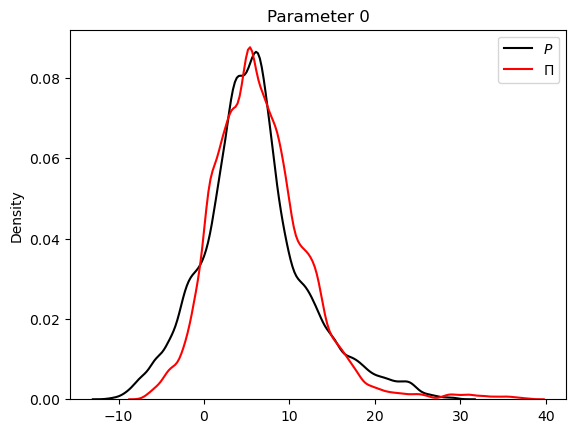

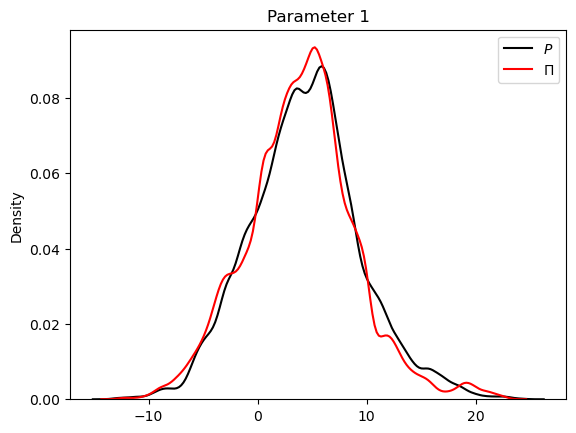

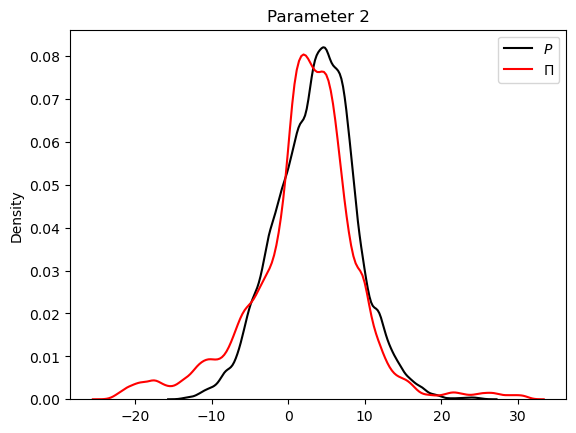

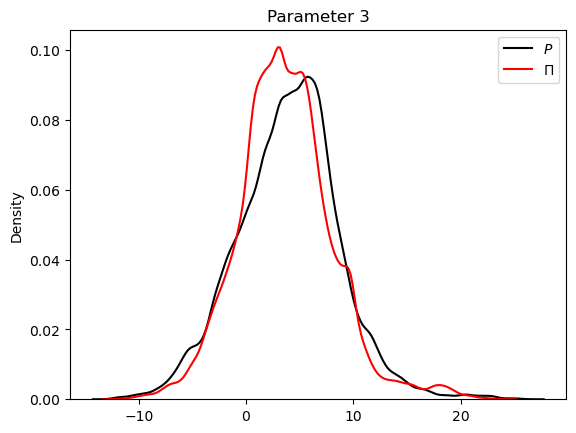

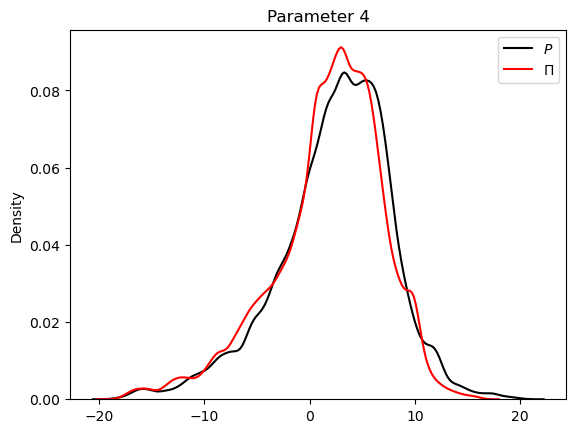

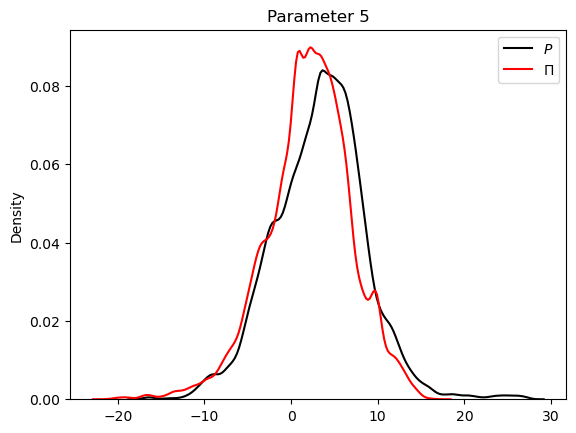

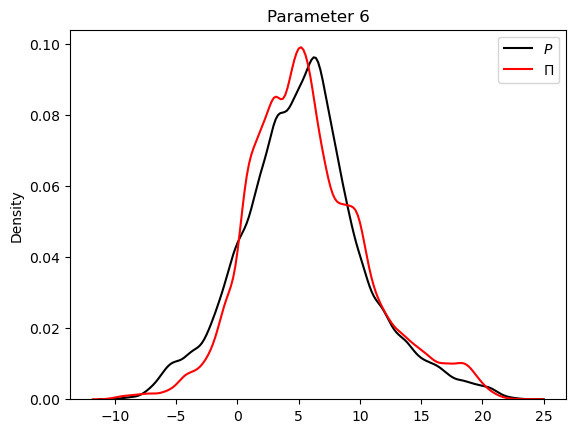

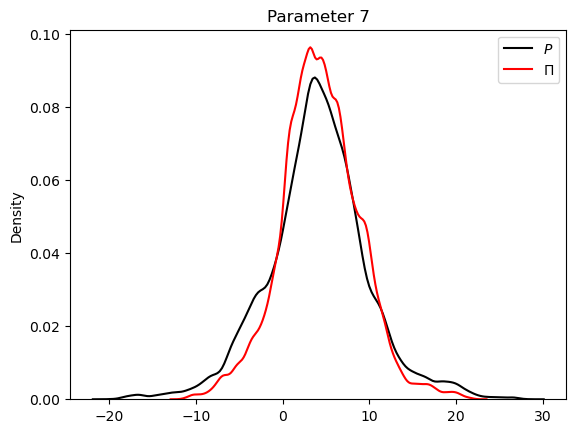

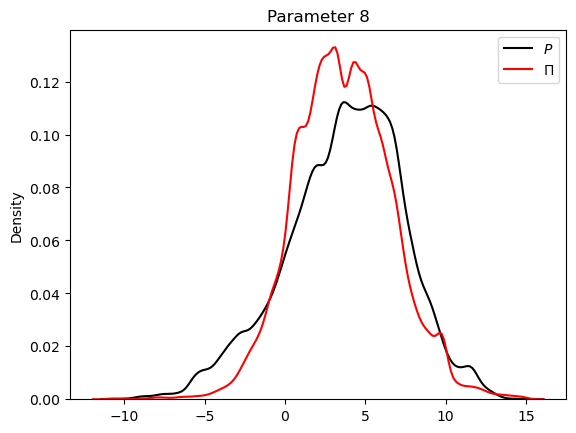

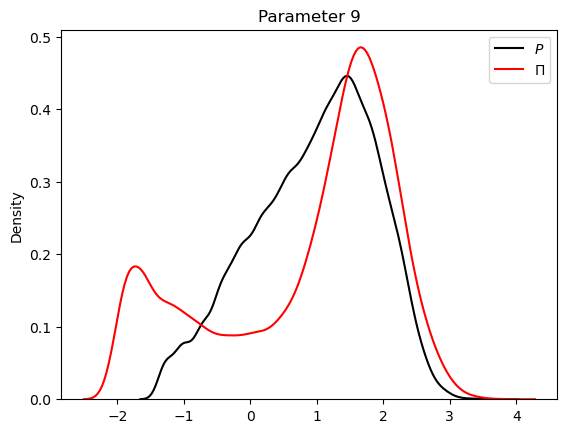

In [9]:
for i in range(dim):
    # plt.hist(x_p_unconstrain[:,i].flatten(), bins=100, density=True, alpha=0.5, label='p')
    # plt.hist(x_q_unconstrain[:,i].flatten(), bins=100, density=True, alpha=0.5, label='q')
    sns.kdeplot(x_p_unconstrain[:,i].flatten(), label='$P$', color="black")
    sns.kdeplot(x_q_unconstrain[:,i].flatten(), label='$\Pi$', color="red")

    plt.title(f"Parameter {i}")
    plt.legend()
    plt.show()

### Thinning

In [10]:
fixed_ratio = 0.1
iteration_list = [10, 20, 50, 100, 200, 500, 1000, 2000]

#IMQ
vfk0_imq = make_imq(x_p_unconstrain, grad_x_p_unconstrain, pre=nearestPD(linv))

res_ksd_p_imq = []
res_ksd_q_imq = []
res_ksd_p_thinning_imq = []
res_ksd_q_thinning_imq = []

In [12]:
# IMQ Thinning
# Compute KSD
for i in iteration_list:
    thinning_number = int(fixed_ratio * i)

    x_p_unconstrain_cutting = x_p_unconstrain[0:i,:]
    x_q_unconstrain_cutting = x_q_unconstrain[0:i,:]
    grad_x_p_unconstrain_cutting = grad_x_p_unconstrain[0:i,:]
    grad_x_q_unconstrain_cutting = grad_x_q_unconstrain[0:i,:]

    idx_p = thin(x_p_unconstrain_cutting,\
                    grad_x_p_unconstrain_cutting,\
                    thinning_number,\
                    pre=nearestPD(linv),\
                    stnd=False)
    idx_q = thin(x_q_unconstrain_cutting,\
                    grad_x_q_unconstrain_cutting,\
                    thinning_number,\
                    pre=nearestPD(linv),\
                    stnd=False)

    x_p_thinning_unconstrain_cutting = x_p_unconstrain_cutting[idx_p]
    grad_x_p_thinning_unconstrain_cutting = grad_x_p_unconstrain_cutting[idx_p]

    x_q_thinning_unconstrain_cutting = x_q_unconstrain_cutting[idx_p]
    grad_x_q_thinning_unconstrain_cutting = grad_x_q_unconstrain_cutting[idx_p]

    ks_p = ksd(x_p_unconstrain_cutting, grad_x_p_unconstrain_cutting, vfk0_imq)
    ks_p_thinning = ksd(x_p_thinning_unconstrain_cutting, grad_x_p_thinning_unconstrain_cutting, vfk0_imq)

    ks_q = ksd(x_q_unconstrain_cutting, grad_x_q_unconstrain_cutting, vfk0_imq)
    ks_q_thinning = ksd(x_q_thinning_unconstrain_cutting, grad_x_q_thinning_unconstrain_cutting, vfk0_imq)

    print(i, ks_p_thinning[-1])
    print(i, ks_q_thinning[-1])

    res_ksd_p_imq.append(ks_p[-1])
    res_ksd_q_imq.append(ks_q[-1])

    res_ksd_p_thinning_imq.append(ks_p_thinning[-1])
    res_ksd_q_thinning_imq.append(ks_q_thinning[-1])

10 2.641579260846438
10 7.095676927641847
20 1.9553140864477951
20 3.3760127987938744
50 1.4139240574100398
50 2.997874678344178
100 1.0076022851683013
100 1.9840000198937529
200 0.8059354696822825
200 1.7844153596944121
500 0.4674232398758433
500 6.642848828097075
1000 0.3270199430889564
1000 7.62394306563923
2000 0.21478797775281763
2000 4.708500480132747


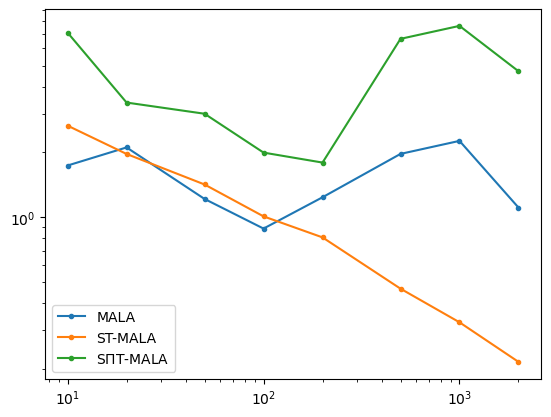

In [13]:
plt.loglog(iteration_list, res_ksd_p_imq, label="MALA", marker=".")
# plt.loglog(iteration_list, res_ksd_q_imq, label="$Pi$", marker=".")
plt.loglog(iteration_list, res_ksd_p_thinning_imq, label="ST-MALA", marker=".")
plt.loglog(iteration_list, res_ksd_q_thinning_imq, label="S$\Pi$T-MALA", marker=".")
plt.legend()

In [14]:
#KGM
vfk0_centkgm = make_centkgm(x_p_unconstrain, grad_x_p_unconstrain, x_map=x_unconstrain_map, pre=nearestPD(linv), s=s)

res_ksd_p_centkgm = []
res_ksd_q_centkgm = []
res_ksd_p_thinning_centkgm = []
res_ksd_q_thinning_centkgm = []

In [15]:
# KGM Thinning
# Compute KSD
for i in iteration_list:
    thinning_number = int(fixed_ratio * i)

    # print(f"No.{i} Index Calculation Begin")

    x_p_unconstrain_cutting = x_p_unconstrain[0:i,:]
    x_q_unconstrain_cutting = x_q_unconstrain[0:i,:]
    grad_x_p_unconstrain_cutting = grad_x_p_unconstrain[0:i,:]
    grad_x_q_unconstrain_cutting = grad_x_q_unconstrain[0:i,:]

    idx_p = thin(x_p_unconstrain_cutting,\
                    grad_x_p_unconstrain_cutting,\
                    thinning_number,\
                    pre=nearestPD(linv),\
                    stnd=False,
                    kern='centkgm',
                    xmp=x_unconstrain_map
                    )
    idx_q = thin(x_q_unconstrain_cutting,\
                    grad_x_q_unconstrain_cutting,\
                    thinning_number,\
                    pre=nearestPD(linv),\
                    stnd=False,
                    kern='centkgm',
                    xmp=x_unconstrain_map)

    x_p_thinning_unconstrain_cutting = x_p_unconstrain_cutting[idx_p]
    grad_x_p_thinning_unconstrain_cutting = grad_x_p_unconstrain_cutting[idx_p]

    x_q_thinning_unconstrain_cutting = x_q_unconstrain_cutting[idx_p]
    grad_x_q_thinning_unconstrain_cutting = grad_x_q_unconstrain_cutting[idx_p]

    ks_p = ksd(x_p_unconstrain_cutting, grad_x_p_unconstrain_cutting, vfk0_centkgm)
    ks_p_thinning = ksd(x_p_thinning_unconstrain_cutting, grad_x_p_thinning_unconstrain_cutting, vfk0_centkgm)

    ks_q = ksd(x_q_unconstrain_cutting, grad_x_q_unconstrain_cutting, vfk0_centkgm)
    ks_q_thinning = ksd(x_q_thinning_unconstrain_cutting, grad_x_q_thinning_unconstrain_cutting, vfk0_centkgm)

    print(i, ks_p_thinning[-1])
    print(i, ks_q_thinning[-1])

    res_ksd_p_centkgm.append(ks_p[-1])
    res_ksd_q_centkgm.append(ks_q[-1])

    res_ksd_p_thinning_centkgm.append(ks_p_thinning[-1])
    res_ksd_q_thinning_centkgm.append(ks_q_thinning[-1])

10 13.577602144081172
10 180.97375336440524
20 9.655109597663028
20 62.33466635749774
50 6.545025964497613
50 34.80530311452572
100 4.515316906716107
100 24.341235799320295
200 3.415193948685901
200 62.68350806307475
500 1.9016320648880947
500 154.08034267586075
1000 1.3273902411289193
1000 158.42045625836627
2000 0.8752823851394211
2000 123.07268427267438


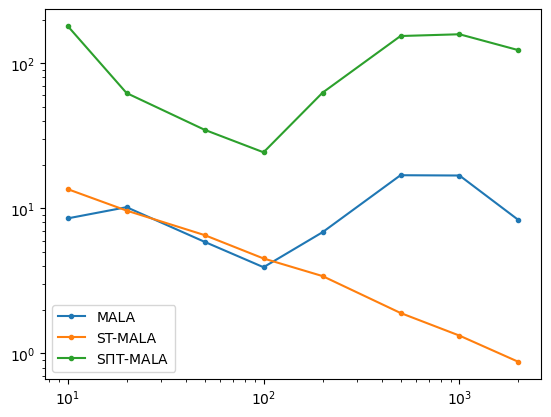

In [16]:
plt.loglog(iteration_list, res_ksd_p_centkgm, label="MALA", marker=".")
# plt.loglog(iteration_list, res_ksd_q_centkgm, label="$Pi$", marker=".")
plt.loglog(iteration_list, res_ksd_p_thinning_centkgm, label="ST-MALA", marker=".")
plt.loglog(iteration_list, res_ksd_q_thinning_centkgm, label="S$\Pi$T-MALA", marker=".")
plt.legend()

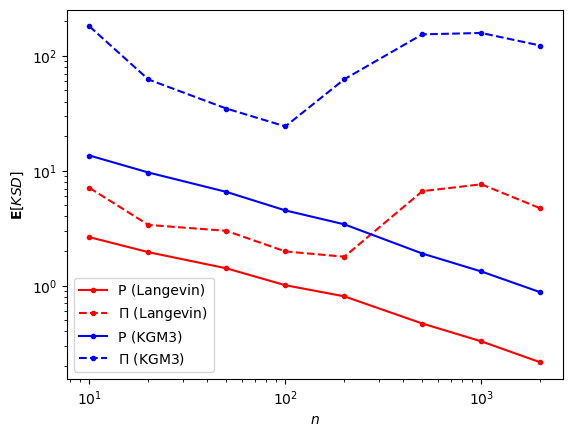

In [17]:
plt.loglog(iteration_list, res_ksd_p_thinning_imq, marker=".", color="red", linestyle="-", label="P (Langevin)")
plt.loglog(iteration_list, res_ksd_q_thinning_imq, marker=".", color="red", linestyle="--", label="$\Pi$ (Langevin)")

plt.loglog(iteration_list, res_ksd_p_thinning_centkgm, marker=".", color="blue", linestyle="-", label="P (KGM3)")
plt.loglog(iteration_list, res_ksd_q_thinning_centkgm, marker=".", color="blue", linestyle="--", label="$\Pi$ (KGM3)")

plt.xlabel('$n$')
plt.ylabel(r'$\bf{E}$[$KSD$]')
plt.legend()

### WasserStein

In [18]:
gs = np.zeros_like(gs_chains.T)
# gs = np.zeros_like(gs_matrix)

for i in range(gs_chains.T.shape[0]):
    gs[i] = model.param_unconstrain(gs_chains.T[i].astype(np.float64))
# for i in range(gs_matrix.shape[0]):
#     gs[i] = model.param_unconstrain(gs_matrix[i].astype(np.float64))
emd = wasserstein.EMD(n_iter_max=1_000_000)
gs_weights = np.repeat(1/gs.shape[0], gs.shape[0])

In [19]:
#IMQ
res_wass_p_imq = []
res_wass_q_imq = []
res_wass_p_thinning_imq = []
res_wass_q_thinning_imq = []

In [20]:
# IMQ Thinning
# Compute WasserStein
for i in iteration_list:
    thinning_number = int(fixed_ratio * i)

    x_p_unconstrain_cutting = x_p_unconstrain[0:i,:]
    x_q_unconstrain_cutting = x_q_unconstrain[0:i,:]
    grad_x_p_unconstrain_cutting = grad_x_p_unconstrain[0:i,:]
    grad_x_q_unconstrain_cutting = grad_x_q_unconstrain[0:i,:]

    idx_p = thin(x_p_unconstrain_cutting,\
                    grad_x_p_unconstrain_cutting,\
                    thinning_number,\
                    pre=nearestPD(linv),\
                    stnd=False)
    idx_q = thin(x_q_unconstrain_cutting,\
                    grad_x_q_unconstrain_cutting,\
                    thinning_number,\
                    pre=nearestPD(linv),\
                    stnd=False)

    x_p_thinning_unconstrain_cutting = x_p_unconstrain_cutting[idx_p]
    # grad_x_p_thinning_unconstrain_cutting = grad_x_p_unconstrain_cutting[idx_p]

    x_q_thinning_unconstrain_cutting = x_q_unconstrain_cutting[idx_p]
    # grad_x_q_thinning_unconstrain_cutting = grad_x_q_unconstrain_cutting[idx_p]

    original_weights = np.repeat(1/i, i)
    thinning_weights = np.repeat(1/thinning_number, thinning_number)

    wass_p = emd(original_weights, x_p_unconstrain_cutting, gs_weights, gs)
    wass_p_thinning = emd(thinning_weights, x_p_thinning_unconstrain_cutting, gs_weights, gs)

    wass_q = emd(original_weights, x_q_unconstrain_cutting, gs_weights, gs)
    wass_q_thinning = emd(thinning_weights, x_q_thinning_unconstrain_cutting, gs_weights, gs)

    print(i, wass_p_thinning)
    print(i, wass_q_thinning)

    res_wass_p_imq.append(wass_p)
    res_wass_q_imq.append(wass_q)

    res_wass_p_thinning_imq.append(wass_p_thinning)
    res_wass_q_thinning_imq.append(wass_q_thinning)

10 16.068718570725583
10 22.260577699457308
20 15.97964938430535
20 21.791165943357466
50 16.01112935518701
50 20.528521161697164
100 15.489583948902453
100 19.936360510954778
200 15.069283794101342
200 19.43896876288739
500 14.02303273322089
500 18.07907184652605
1000 13.207705286783039
1000 17.73137567929333
2000 8.70976431847939
2000 14.500880594124098


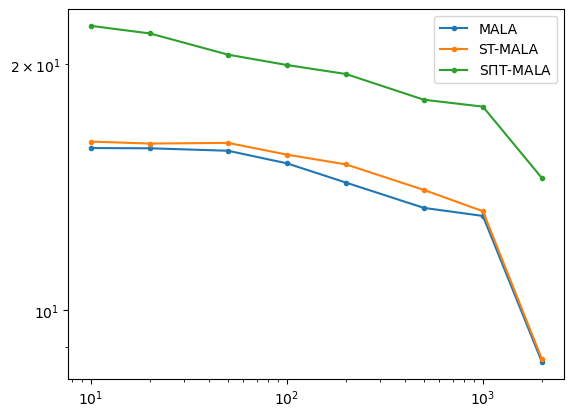

In [21]:
plt.loglog(iteration_list, res_wass_p_imq, label="MALA", marker=".")
plt.loglog(iteration_list, res_wass_p_thinning_imq, label="ST-MALA", marker=".")
plt.loglog(iteration_list, res_wass_q_thinning_imq, label="S$\Pi$T-MALA", marker=".")
plt.legend()

In [22]:
#KGM
res_wass_p_centkgm = []
res_wass_q_centkgm = []
res_wass_p_thinning_centkgm = []
res_wass_q_thinning_centkgm = []

In [23]:
# KGM Thinning
# Compute WasserStein
for i in iteration_list:
    thinning_number = int(fixed_ratio * i)

    x_p_unconstrain_cutting = x_p_unconstrain[0:i,:]
    x_q_unconstrain_cutting = x_q_unconstrain[0:i,:]
    grad_x_p_unconstrain_cutting = grad_x_p_unconstrain[0:i,:]
    grad_x_q_unconstrain_cutting = grad_x_q_unconstrain[0:i,:]

    idx_p = thin(x_p_unconstrain_cutting,\
                    grad_x_p_unconstrain_cutting,\
                    thinning_number,\
                    pre=nearestPD(linv),\
                    stnd=False,
                    kern='centkgm',
                    xmp=x_unconstrain_map
                    )
    idx_q = thin(x_q_unconstrain_cutting,\
                    grad_x_q_unconstrain_cutting,\
                    thinning_number,\
                    pre=nearestPD(linv),\
                    stnd=False,
                    kern='centkgm',
                    xmp=x_unconstrain_map)

    x_p_thinning_unconstrain_cutting = x_p_unconstrain_cutting[idx_p]
    # grad_x_p_thinning_unconstrain_cutting = grad_x_p_unconstrain_cutting[idx_p]

    x_q_thinning_unconstrain_cutting = x_q_unconstrain_cutting[idx_p]
    # grad_x_q_thinning_unconstrain_cutting = grad_x_q_unconstrain_cutting[idx_p]

    original_weights = np.repeat(1/i, i)
    thinning_weights = np.repeat(1/thinning_number, thinning_number)

    wass_p = emd(original_weights, x_p_unconstrain_cutting, gs_weights, gs)
    wass_p_thinning = emd(thinning_weights, x_p_thinning_unconstrain_cutting, gs_weights, gs)

    wass_q = emd(original_weights, x_q_unconstrain_cutting, gs_weights, gs)
    wass_q_thinning = emd(thinning_weights, x_q_thinning_unconstrain_cutting, gs_weights, gs)

    print(i, wass_p_thinning)
    print(i, wass_q_thinning)

    res_wass_p_centkgm.append(wass_p)
    res_wass_q_centkgm.append(wass_q)

    res_wass_p_thinning_centkgm.append(wass_p_thinning)
    res_wass_q_thinning_centkgm.append(wass_q_thinning)

10 16.068718570725583
10 22.260577699457308
20 16.11946428808353
20 21.87354924467046
50 15.740102678954328
50 20.986763444604488
100 15.270863440631883
100 20.026910065485737
200 14.559535928626405
200 19.018201226388292
500 13.751652608175233
500 17.823830682350952
1000 12.91190924872717
1000 17.68450764038227
2000 8.78327767382657
2000 16.07354610132163


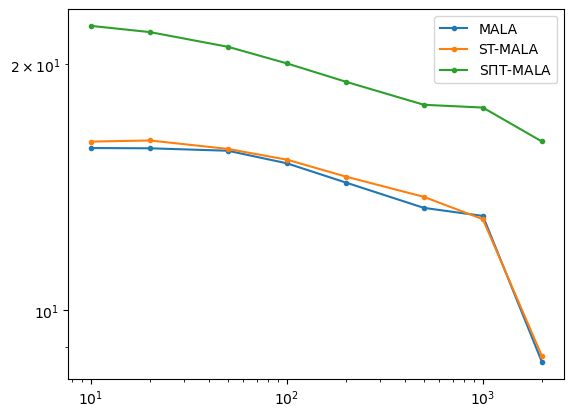

In [24]:
plt.loglog(iteration_list, res_wass_p_centkgm, label="MALA", marker=".")
plt.loglog(iteration_list, res_wass_p_thinning_centkgm, label="ST-MALA", marker=".")
plt.loglog(iteration_list, res_wass_q_thinning_centkgm, label="S$\Pi$T-MALA", marker=".")
plt.legend()

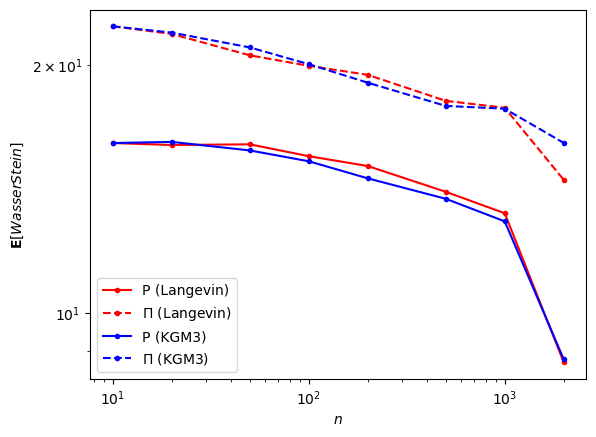

In [25]:
plt.loglog(iteration_list, res_wass_p_thinning_imq, marker=".", color="red", linestyle="-", label="P (Langevin)")
plt.loglog(iteration_list, res_wass_q_thinning_imq, marker=".", color="red", linestyle="--", label="$\Pi$ (Langevin)")

plt.loglog(iteration_list, res_wass_p_thinning_centkgm, marker=".", color="blue", linestyle="-", label="P (KGM3)")
plt.loglog(iteration_list, res_wass_q_thinning_centkgm, marker=".", color="blue", linestyle="--", label="$\Pi$ (KGM3)")

plt.xlabel('$n$')
plt.ylabel(r'$\bf{E}$[$WasserStein$]')
plt.legend()